In [1]:
import subprocess

def kill_cuda_processes():
    # Get the list of process IDs (PIDs) using nvidia-smi
    cmd = "nvidia-smi | grep 'python' | awk '{print $3}'"
    pids_str = subprocess.check_output(cmd, shell=True).decode('utf-8')
    pids = pids_str.split('\n')[:-1]

    # Kill each process by its PID
    for pid in pids:
        try:
            subprocess.run(["kill", "-9", pid])
            print(f"Killed process {pid}")
        except Exception as e:
            print(f"Error killing process {pid}: {e}")

# Run the function
kill_cuda_processes()


In [2]:
#Set this cuda variable
import os

# Set the environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print("There are %d GPU(s) available." % torch.cuda.device_count())

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not...
elif torch.backends.mps.is_available():
    device = torch.device("mps")

    print("Using mps backend")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [4]:
torch.cuda.empty_cache()

In [5]:
train_dataset = torch.load('train_dataset_kandisky_bert_magicbrush.pth')
dev_dataset = torch.load('dev_dataset_kandisky_bert_magicbrush.pth')

In [6]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=16
)

validation_dataloader = DataLoader(
    dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=16
)

In [7]:
from transformers import AutoTokenizer, AutoProcessor
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import requests
from PIL import Image
import numpy as np
from io import BytesIO
from diffusers import (
    KandinskyV22Pipeline,
    KandinskyV22PriorEmb2EmbPipeline,
    KandinskyV22PriorPipeline,
)
from diffusers.utils import load_image
from torchvision.transforms import ToPILImage

In [8]:
from transformers import CLIPTextModelWithProjection, CLIPVisionModelWithProjection, BertModel
import torch.nn as nn
from transformers import AdamW
import os


class T2IModel(nn.Module):
    def __init__(self):
        super(T2IModel, self).__init__()
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.vision_model = CLIPVisionModelWithProjection.from_pretrained(
            "kandinsky-community/kandinsky-2-2-prior", subfolder="image_encoder"
        )
        # Adjust the input features of the FC layer to the combined size of text and vision outputs
        self.fc = nn.Linear(self.text_model.config.hidden_size + self.vision_model.config.projection_dim, 1280)


    def initialize_optimizer(self):
        params = (
            list(self.fc.parameters())
        )
        optimizer = AdamW(params, lr=1e-4)
        return optimizer

    def forward(self, input_imgs, input_txt, attention_mask=None):
        text_outputs = self.text_model(input_txt, attention_mask=attention_mask)
        text_embeds = text_outputs.last_hidden_state[:, 0, :]  # Use the representation of the [CLS] token

        vision_outputs = self.vision_model(input_imgs)
        vision_embeds = vision_outputs.image_embeds

        combined_embeds = torch.cat((vision_embeds, text_embeds), dim=1)
        x = self.fc(combined_embeds)
        return x

    def output_embedding(self, target_images):
        target_image_output = self.vision_model(target_images)
        target_image_embeds = target_image_output.image_embeds
        return target_image_embeds

    def custom_loss(self, output_embeddings, target_embeddings):
        mse_loss = nn.MSELoss()
        loss = mse_loss(output_embeddings, target_embeddings)

        return loss

    def save_model(self, output_dir="../model_save/", filename="model_checkpoint.pt"):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        file_path = output_dir + filename
        print("Saving model to %s" % file_path)

        torch.save(model.state_dict(), file_path)

    def get_cos(self, input1, input2):
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity = cos(input1, input2)
        avg = torch.sum(similarity) / len(similarity)
        return avg

    def metrics(self, input1, input2):
        cos = self.get_cos(input1, input2)
        return [cos]

    def visualization(self, input_img, instruction, instruction_attention_mask, filename, negative_instruction=None, negative_instruction_attention_mask=None):
        # Generate output embeddings with the provided attention mask
        output_embeddings = self.forward(input_img, instruction, attention_mask=instruction_attention_mask)

        # Handle the negative instruction if provided
        neg_image_embed = None
        if negative_instruction is not None and negative_instruction_attention_mask is not None:
            neg_image_embed = self.forward(input_img, negative_instruction, attention_mask=negative_instruction_attention_mask)
        else:
            # If no negative instruction is provided, we'll use a tensor of zeros as a placeholder
            neg_image_embed = torch.zeros_like(output_embeddings)

        # Initialize the pipeline for the Kandinsky V2.2 decoder
        pipe = KandinskyV22Pipeline.from_pretrained(
            "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16
        )
        pipe.to(device) 
        
        # Generate the image using the pipeline
        image = pipe(
            image_embeds=output_embeddings,
            negative_image_embeds=neg_image_embed,
            height=768,
            width=768,
            num_inference_steps=100,
        ).images

        # Save the generated image
        image[0].save(filename)

model = T2IModel()
model.to(device=device)

T2IModel(
  (text_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [9]:
optimizer = model.initialize_optimizer()

/home/sadibha2/.local/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Use the below cell not to retrain but load the model

In [ ]:
import torch

def load_model_from_checkpoint(model, checkpoint_path, device='cuda'):
    """
    Load a PyTorch model from a saved checkpoint.
    
    Parameters:
    - model (torch.nn.Module): The model architecture (untrained).
    - checkpoint_path (str): Path to the saved model checkpoint (.pth file).
    - device (str): Device to which the model should be loaded ('cuda' or 'cpu').

    Returns:
    - model (torch.nn.Module): Model populated with the loaded weights.
    """

    # Load the model state dictionary from the specified path
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    
    # Move the model to the desired device
    model.to(device)
    
    return model

# Usage
loaded_model = load_model_from_checkpoint(model, 'magicbrush_imagewithinstruction_10epochs_full_v2.pth', device='cuda')


### Use the below cell only to re-train or else don't execute

In [10]:
from transformers import BertTokenizer
import torch
from tqdm.notebook import tqdm

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T2IModel().to(device)
optimizer = model.initialize_optimizer()

num_epochs = 10
training_stats = []

for epoch in range(num_epochs):
    print(f'\n======== Epoch {epoch + 1} / {num_epochs} ========')
    print('Training...')

    total_train_loss = 0
    model.train()

    for batch in tqdm(train_dataloader, desc="Training"):
        optimizer.zero_grad()

        # Convert textual input to the right format
        instructions = batch[1]
        if isinstance(instructions, torch.Tensor):
            instructions = instructions.tolist()
        if not isinstance(instructions[0], str):
            instructions = [tokenizer.decode(text_input) for text_input in instructions]

        inputs = tokenizer(instructions, padding=True, truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].to(device)
        attention_masks = inputs['attention_mask'].to(device)

        # Prepare image data
        input_images = batch[0].to(device)
        target_images = batch[2].to(device)

        # Forward pass
        output_embeddings = model(input_images, input_ids, attention_mask=attention_masks)

        # Generate target embeddings
        target_img_embeddings = model.output_embedding(target_images)

        # Calculate loss
        loss = model.custom_loss(output_embeddings, target_img_embeddings)
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Clear memory
        del input_images, input_ids, attention_masks, target_images, output_embeddings, target_img_embeddings, loss

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Average training loss: {avg_train_loss:.2f}")

    # Validation phase
    print("\nRunning Validation...")
    model.eval()

    total_eval_loss = 0
    avg_cos = 0

    for batch in tqdm(validation_dataloader, desc="Validation"):
        with torch.no_grad():
            # Convert textual input to the right format
            instructions = batch[1]
            if isinstance(instructions, torch.Tensor):
                instructions = instructions.tolist()
            if not isinstance(instructions[0], str):
                instructions = [tokenizer.decode(text_input) for text_input in instructions]

            inputs = tokenizer(instructions, padding=True, truncation=True, return_tensors="pt")
            input_ids = inputs['input_ids'].to(device)
            attention_masks = inputs['attention_mask'].to(device)

            # Prepare image data
            input_images = batch[0].to(device)
            target_images = batch[2].to(device)

            # Forward pass
            output_embeddings = model(input_images, input_ids, attention_mask=attention_masks)
            target_img_embeddings = model.output_embedding(target_images)

            # Calculate loss
            loss = model.custom_loss(output_embeddings, target_img_embeddings)
            total_eval_loss += loss.item()
            avg_cos += model.get_cos(output_embeddings, target_img_embeddings).item()

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_cos /= len(validation_dataloader)
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation Cosine Similarity: {avg_cos:.2f}")

    # Store the statistics
    training_stats.append({
        "epoch": epoch + 1,
        "Training Loss": avg_train_loss,
        "Validation Loss": avg_val_loss,
        "Validation Cosine Similarity": avg_cos,
    })

print("Training completed!")



======== Epoch 1 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.72

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.52
  Validation Cosine Similarity: 0.79

======== Epoch 2 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.42

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.38
  Validation Cosine Similarity: 0.85

======== Epoch 3 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.33

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.33
  Validation Cosine Similarity: 0.87

======== Epoch 4 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.28

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.29
  Validation Cosine Similarity: 0.89

======== Epoch 5 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.26

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.27
  Validation Cosine Similarity: 0.89

======== Epoch 6 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.24

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.26
  Validation Cosine Similarity: 0.90

======== Epoch 7 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.23

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.25
  Validation Cosine Similarity: 0.90

======== Epoch 8 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.23

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.25
  Validation Cosine Similarity: 0.91

======== Epoch 9 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.22

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.24
  Validation Cosine Similarity: 0.91

======== Epoch 10 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.22

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.24
  Validation Cosine Similarity: 0.91
Training completed!


In [11]:
torch.save(model.state_dict(), 'magicbrush_kadinsky_bert_imagewithinstruction_10epochs_full_v1.pth')

In [ ]:
def compute_max_instruction_length(dataloader, tokenizer):
    """
    Compute the maximum instruction length from the dataloader batches.

    Args:
    - dataloader (DataLoader): DataLoader containing your data.
    - tokenizer: Tokenizer used to tokenize the instructions.

    Returns:
    - int: Maximum instruction length.
    """
    max_len = 0
    
    for batch in dataloader:
        instructions = batch[1]  # Assuming instructions are in position 1 in your batch
        for instruction in instructions:
            decoded_string = tokenizer.decode(instruction)
            tokens = tokenizer.tokenize(decoded_string)
            length = len(tokens)
            if length > max_len:
                max_len = length
                
    return max_len

def custom_encode(instruction, max_len, tokenizer):
    encoded_inst = tokenizer.encode_plus(
    instruction,  # Sentence to encode.
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=max_len + 10,  # Pad & truncate all sentences.
    pad_to_max_length=True,
    padding="max_length",
    return_tensors="pt",  # Return pytorch tensors
    )
    
    return encoded_inst["input_ids"]
    

In [ ]:
from PIL import Image
img = Image.open("cat1.png")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

input_image = processor(images=img, return_tensors="pt")["pixel_values"]

max_len = compute_max_instruction_length(train_dataloader, tokenizer)

instruction = "Put a toy in the cat's mouth."
instruction_1 = "Low quality image"

input_image = input_image.to(device)
instruction = custom_encode(instruction,max_len,tokenizer).to(device)
instruction_1 = custom_encode(instruction_1,max_len,tokenizer).to(device)

model.visualization(input_image, instruction, instruction_1)

## Run the below code for plotting metrics

In [12]:
import pandas as pd

pd.set_option("display.precision", 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index("epoch")
df_stats

,Training Loss,Validation Loss,Validation Cosine Similarity
epoch,,,
1,0.72,0.52,0.79
2,0.42,0.38,0.85
3,0.33,0.33,0.87
4,0.28,0.29,0.89
5,0.26,0.27,0.89
6,0.24,0.26,0.90
7,0.23,0.25,0.90
8,0.23,0.25,0.91
9,0.22,0.24,0.91


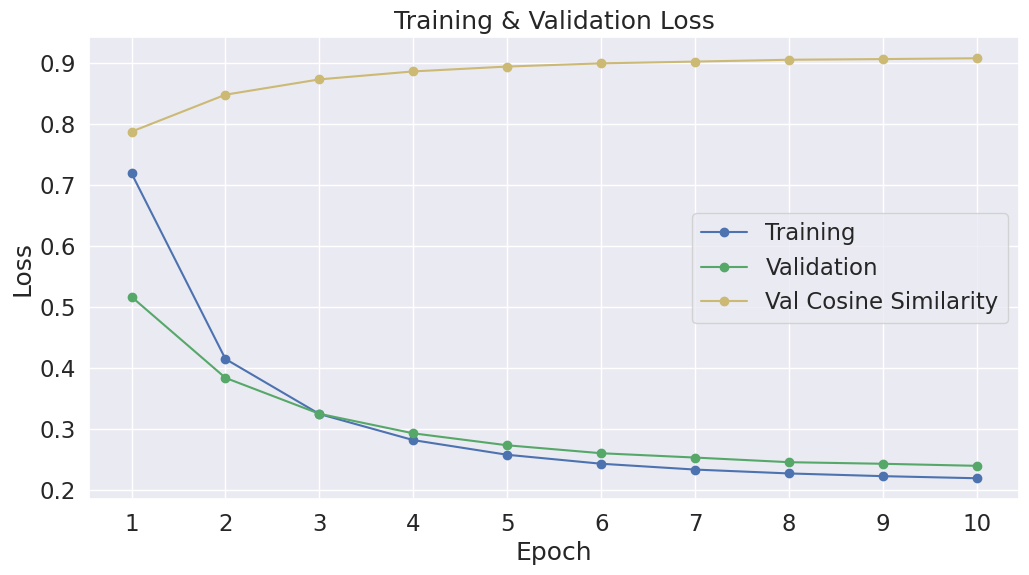

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns


# Use plot styling from seaborn.
sns.set(style="darkgrid")

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(df_stats["Training Loss"], "b-o", label="Training")
plt.plot(df_stats["Validation Loss"], "g-o", label="Validation")
plt.plot(df_stats["Validation Cosine Similarity"], "y-o", label="Val Cosine Similarity")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)

plt.show()